# Классификация, деревья решений и метод ближайших соседей
[Лекция](https://habrahabr.ru/company/ods/blog/322534/)

## Деревья решений

**Энтропия Шеннона** для системы с $N$ возможными состояниями: $$S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$ где $p_i$ -- вероятность нахождения системы в $i$-м состоянии.


Хотим так бить группу объектов на подгруппы, чтобы получать наибольший **прирост информации** (information gain, IG): при разбиении выборки по признаку Q он определяется как
$$IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$
где q – число групп после разбиения, Ni – число элементов выборки, у которых признак Q имеет i-ое значение.


В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип **жадной максимизации** прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева.

Другие эвристики разбиения по признаку:
* Неопределенность Джини (Gini impurity): $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/esokolov/ml-course-hse) Евгения Соколова. Не путать с индексом Джини! Подробнее об этой путанице – в [блогпосте](https://alexanderdyakonov.wordpress.com/2015/12/15/знакомьтесь-джини/) Александра Дьяконова
* Ошибка классификации (misclassification error): $E = 1 - \max\limits_k p_k$
На практике ошибка классификации почти не используется, а неопределенность Джини и прирост информации работают почти одинаково.

### Синтетический пример

#### Генерация данных

In [2]:
import numpy as np

# первый класс
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

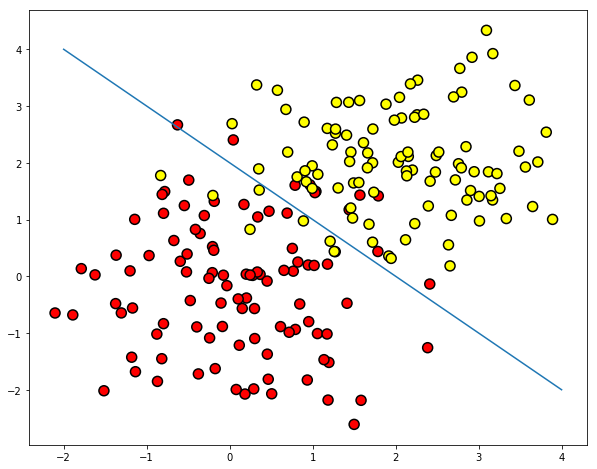

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1))

#### Попробуем обучить дерево

Text(0,0.5,'x2')

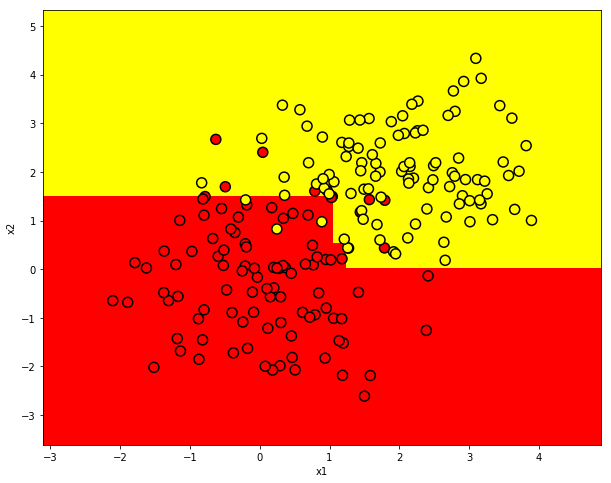

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.xlabel('x1'); plt.ylabel('x2')

#### Нарисуем полученное дерево

In [23]:
# используем .dot формат для визуализации дерева
from sklearn.tree import export_graphviz

path_to_dot = './img/lenavolzhina/small_tree.dot'
path_to_png = path_to_dot.replace('dot', 'png')

export_graphviz(clf_tree, feature_names=['x1', 'x2'], out_file=path_to_dot, filled=True)

# для этого понадобится библиотека pydot (pip install pydot)
!dot -Tpng 'img/lenavolzhina/small_tree.dot' -o 'img/lenavolzhina/small_tree.png'

Отрисовываем:
![title](img/lenavolzhina/small_tree.png)

### Количественные признаки

#### Эвристики для выбора числа порогов для перебора
* Cамая простая эвристика для обработки количественных признаков в дереве решений: количественный признак сортируется по возрастанию, и в дереве проверяются только те пороги, при которых целевой признак меняет значение
* Дополнительно, когда в данных много количественных признаков, и у каждого много уникальных значений, могут отбираться не все пороги, описанные выше, а только топ-N, дающих максимальный прирост все того же критерия. То есть, по сути, для каждого порога строится дерево глубины 1, считается насколько снизилась энтропия (или неопределенность Джини) и выбираются только лучшие пороги, с которыми стоит сравнивать количественный признак.

###  Основные параметры дерева

Можно ограничивать глубину дерева и / или минимальное число объектов в листе.

Два исключения, когда строим по максимуму: случайный лес и стрижка дерева (pruning) по кросс-валидации


Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

* max_depth – максимальная глубина дерева
* max_features — максимальное число признаков, по которым ищется лучшее разбиение в дереве
* min_samples_leaf – минимальное число объектов в листе

### Задача регрессии
Критерий качества -- дисперсия вокруг среднего: $$D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2,$$
где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.


## Метод ближайших соседей

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

* Вычислить расстояние до каждого из объектов обучающей выборки
* Отобрать k объектов обучающей выборки, расстояние до которых минимально
* Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Под задачу регрессии метод адаптируется довольно легко – на 3 шаге возвращается не метка, а число – среднее (или медианное) значение целевого признака среди соседей.

Ленивый метод, используется как вспомогательный -- для мета-признаков или стекинга/блендинга

#### Класс KNeighborsClassifier в Scikit-learn

Основные параметры класса [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

* weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
* algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
* leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
* metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

## Выбор параметров и кросс-валидация
Чтобы проверить способность обобщаться, используем один из двух способов:
* отложенная выборка (held-out / hold-out)
* кросс-валидация, чаще всего k-fold

## Плюсы и минусы деревьев решений и метода ближайших соседей

### Плюсы и минусы деревьев решений

#### Плюсы:

* Порождение четких правил классификации, понятных человеку, это свойство называют интерпретируемостью модели;
* Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
* Быстрые процессы обучения и прогнозирования;
* Малое число параметров модели;
* Поддержка и числовых, и категориальных признаков.

#### Минусы:

* У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
* Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
* Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение — проблема всех методов машинного обучения;
* Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
* Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
* Сложно поддерживаются пропуски в данных. Friedman оценил, что на поддержку пропусков в данных ушло около 50% кода CART (классический алгоритм построения деревьев классификации и регрессии – Classification And Regression Trees, в sklearn реализована улучшенная версия именно этого алгоритма);
* Модель умеет только интерполировать, но не экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.

### Плюсы и минусы метода ближайших соседей

#### Плюсы:

* Простая реализация;
* Неплохо изучен теоретически;
* Как правило, метод хорош для первого решения задачи, причем не только классификации или регрессии, но и, например, рекомендации;
* Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же). Кстати, профессор ВМК МГУ и опытный участник соревнований по анализу данных Александр Дьяконов любит самый простой kNN, но с настроенной метрикой сходства объектов. Можно почитать про некоторые его решения (в частности, "VideoLectures.Net Recommender System Challenge") на персональном [сайте](http://alexanderdyakonov.narod.ru/contests.htm);
* Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").

#### Минусы:

* Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
* Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
* Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
* Нет теоретических оснований выбора определенного числа соседей — только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
* Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности". Про это хорошо рассказывает известный в ML-сообществе профессор Pedro Domingos – [тут](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) в популярной статье "A Few Useful Things to Know about Machine Learning", также "the curse of dimensionality" описывается в книге Deep Learning в [главе](http://www.deeplearningbook.org/contents/ml.html) "Machine Learning basics".